In [594]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split


In [595]:
#Limpieza del dataset como en TP1

oportunidades = pd.read_csv("Train_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
oportunidades = oportunidades.dropna()
oportunidades

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,2015-04-21,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None
5,16802,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,2013-07-27,...,Q1,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None
7,27455,Americas,NW America,1,1,1,1,0,Bureaucratic_Code_4,2015-04-21,...,Q1,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None
23,28524,APAC,India,1,1,1,1,0,Bureaucratic_Code_4,2015-10-13,...,Q1,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16922,18519,APAC,Japan,1,1,1,1,0,Bureaucratic_Code_4,2013-07-28,...,Q1,2016,NaT,0,USD,13200.0,USD,6422400.6,Closed Won,Prod_Category_A_None
16923,27689,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,Q1,2016,NaT,0,JPY,12194000.0,JPY,12194000.0,Closed Won,Prod_Category_A_None
16924,27688,APAC,Japan,1,1,0,0,0,Bureaucratic_Code_4,2015-06-11,...,Q1,2016,NaT,0,JPY,11959500.0,JPY,11959500.0,Closed Won,Prod_Category_A_None
16925,19062,APAC,Japan,0,0,0,0,0,Bureaucratic_Code_4,2013-08-11,...,Q1,2016,NaT,0,JPY,17537000.0,JPY,17537000.0,Closed Won,Prod_Category_A_None


In [596]:
#Añadimos la columna binaria de si es aprobada o no.

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})
oportunidades.head()

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
2,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
4,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None
5,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,Q1,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None
7,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,Q1,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None
23,28524,APAC,India,1,Bureaucratic_Code_4,2015-10-13,None,India,Account_Name_1147,Opportunity_Name_7036,...,Q1,2016,NaT,3,USD,1621851.0,USD,1621851.0,Closed Won,Prod_Category_A_None


In [597]:
#Encoding de los vendedores con mean encoding respecto del total amount.
encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Encoding_Vendedor
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,2.232794e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,2.232794e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2018,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,2.232794e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2016,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,2.232794e+06
4,21750,Americas,NE America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1814,...,2017,NaT,0,USD,11961.6,USD,0.0,Closed Won,Prod_Category_A_None,2.232794e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,28141,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4988,...,2018,NaT,1,JPY,38976000.0,JPY,38976000.0,Closed Lost,Prod_Category_A_None,5.688996e+07
9721,28084,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4989,...,2018,NaT,1,JPY,56028000.0,JPY,56028000.0,Closed Lost,Prod_Category_A_None,5.688996e+07
9722,28181,APAC,Japan,1,Bureaucratic_Code_1,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_4994,...,2018,NaT,0,JPY,7660800.0,JPY,7660800.0,Closed Lost,Prod_Category_A_None,5.688996e+07
9723,28182,APAC,Japan,1,Bureaucratic_Code_4,2015-07-03,None,Japan,Account_Name_702,Opportunity_Name_8661,...,2019,NaT,0,JPY,825000.0,JPY,825000.0,Closed Won,Prod_Category_A_None,5.688996e+07


In [598]:
#Encoding de los territorios en base al total amount
encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Encoding_Vendedor,Encoding_Territorio
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,NaT,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,NaT,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,NaT,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,NaT,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04
9721,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,NaT,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04
9722,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,NaT,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04
9723,14879,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,NaT,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04


In [599]:
#Encoding de las regiones en base al total amount
encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Encoding_Vendedor,Encoding_Territorio,Encoding_Region
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,28,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,0,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,0,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,14857,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,31762.5,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04,2.951944e+06
9721,14862,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04,2.951944e+06
9722,14868,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04,2.951944e+06
9723,14873,APAC,New Zealand,0,Bureaucratic_Code_5,2017-05-23,Source_7,New Zealand,Account_Name_1857,Opportunity_Name_11725,...,0,USD,28875.0,USD,147262.5,Closed Won,Prod_Category_A_None,3.610676e+06,3.498250e+04,2.951944e+06


In [600]:
#Encoding del tipo de moneda en base al mean del ASP
encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Encoding_Vendedor,Encoding_Territorio,Encoding_Region,Encoding_Moneda
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06,0.421977
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06,0.421977
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,USD,14838277.5,USD,14838277.5,Closed Lost,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06,0.421977
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,USD,50688.0,USD,50688.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06,0.421977
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,USD,2814.0,USD,2814.0,Closed Won,Prod_Category_A_None,2.232794e+06,1.534896e+06,2.250980e+06,0.421977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,AUD,117600.0,AUD,117600.0,Closed Won,Prod_Category_A_None,8.658390e+04,1.042592e+06,2.951944e+06,0.547969
9721,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,AUD,117600.0,AUD,117600.0,Closed Won,Prod_Category_A_None,8.658390e+04,1.042592e+06,2.951944e+06,0.547969
9722,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,AUD,117600.0,AUD,117600.0,Closed Won,Prod_Category_A_None,8.658390e+04,1.042592e+06,2.951944e+06,0.547969
9723,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,AUD,104328.0,USD,0.0,Closed Lost,Prod_Category_A_None,8.658390e+04,1.042592e+06,2.951944e+06,0.547969


In [601]:
#Encoding del Bureaucratic_Code en base a Dummies
oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])], axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Territorio,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,1.534896e+06,2.250980e+06,0.421977,0,0,0,0,1,0,0
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,1.534896e+06,2.250980e+06,0.421977,0,0,0,0,0,1,0
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,1.534896e+06,2.250980e+06,0.421977,0,0,0,0,0,1,0
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,1.534896e+06,2.250980e+06,0.421977,0,0,0,0,1,0,0
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,1.534896e+06,2.250980e+06,0.421977,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,17555,APAC,Australia,1,Bureaucratic_Code_4,2013-10-03,None,Australia,Account_Name_1440,Opportunity_Name_10149,...,1.042592e+06,2.951944e+06,0.547969,0,0,0,0,1,0,0
9721,18413,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10153,...,1.042592e+06,2.951944e+06,0.547969,0,0,0,0,1,0,0
9722,18416,APAC,Australia,1,Bureaucratic_Code_4,2013-07-28,None,Australia,Account_Name_1440,Opportunity_Name_10150,...,1.042592e+06,2.951944e+06,0.547969,0,0,0,0,1,0,0
9723,22188,APAC,Australia,1,Bureaucratic_Code_4,2014-09-19,Source_9,Australia,Account_Name_1642,Opportunity_Name_10445,...,1.042592e+06,2.951944e+06,0.547969,0,0,0,0,1,0,0


In [602]:
#Encoding del Billing Country en base a mean de Total_Amount.
encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Region,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,2.250980e+06,0.421977,0,0,0,0,1,0,0,2.245889e+06
1,16805,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_851,...,2.250980e+06,0.421977,0,0,0,0,0,1,0,2.245889e+06
2,16802,Americas,NW America,0,Bureaucratic_Code_5,2013-07-27,Source_11,United States,Account_Name_1201,Opportunity_Name_939,...,2.250980e+06,0.421977,0,0,0,0,0,1,0,2.245889e+06
3,27455,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8227,...,2.250980e+06,0.421977,0,0,0,0,1,0,0,2.245889e+06
4,21527,Americas,NW America,1,Bureaucratic_Code_4,2013-07-27,Source_11,United States,Account_Name_25,Opportunity_Name_1828,...,2.250980e+06,0.421977,0,0,0,0,1,0,0,2.245889e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,6773,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9426,...,8.201907e+05,0.376488,0,0,0,0,1,0,0,4.164458e+06
9721,6779,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_9496,...,8.201907e+05,0.376488,0,0,0,0,1,0,0,4.164458e+06
9722,6790,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4195,...,8.201907e+05,0.376488,0,0,0,0,1,0,0,4.164458e+06
9723,6762,EMEA,Malta,1,Bureaucratic_Code_4,2017-07-13,Source_13,Malta,Account_Name_600,Opportunity_Name_4194,...,8.201907e+05,0.376488,0,0,0,0,1,0,0,4.164458e+06


In [603]:
#Encoding del Product_Family en base a mean de Total_Amount.
encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Encoding_Moneda,Bureaucratic_Code_0,Bureaucratic_Code_1,Bureaucratic_Code_2,Bureaucratic_Code_3,Bureaucratic_Code_4,Bureaucratic_Code_5,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0.421977,0,0,0,0,1,0,0,2.245889e+06,69490.525
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0.421977,0,0,0,0,1,0,0,2.245889e+06,69490.525
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0.376488,0,0,0,0,1,0,0,8.585832e+05,69490.525
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0.376488,0,0,0,0,1,0,0,1.240120e+06,69490.525
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0.421977,0,0,0,0,0,1,0,9.806871e+05,69490.525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0.421977,0,0,0,0,1,0,0,1.079523e+05,2197.250
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0.421977,0,0,0,0,1,0,0,1.079523e+05,369.600
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0.421977,0,0,0,0,1,0,0,1.079523e+05,2274.300
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0.421977,0,0,0,0,1,0,0,1.079523e+05,3456.000


In [604]:
#Encoding con Dummies de Account_Type

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Bureaucratic_Code_6,Encoding_Billing_Country,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Account_Type_6,None
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,2.245889e+06,69490.525,0,0,0,0,1,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,8.585832e+05,69490.525,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,1.240120e+06,69490.525,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,9.806871e+05,69490.525,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,1.079523e+05,2197.250,1,0,0,0,0,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,1.079523e+05,369.600,1,0,0,0,0,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,1.079523e+05,2274.300,1,0,0,0,0,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,1.079523e+05,3456.000,1,0,0,0,0,0,0


In [605]:
#Encoding de Delivery Terms en base a Dummies
oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,None,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,0,1,0,0,0,0
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,0,0,1,0,0,0,0
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,0,0,1,0,0,0,0,0,0
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,0,0,1,0,0,0,0,0,0
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,0,0,0,1,0,0
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,0,0,0,1,0,0
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,0,0,0,1,0,0
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,0,0,0,1,0,0


In [606]:
#Obtenemos el año de creación de la oportunidad como columna.
oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year
oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Delivery_Terms_0,Delivery_Terms_1,Delivery_Terms_2,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Opportunity_Created_Year
0,27446,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_469,...,0,0,0,0,1,0,0,0,0,2015
1,27442,Americas,NW America,1,Bureaucratic_Code_4,2015-04-21,Source_7,United States,Account_Name_1794,Opportunity_Name_8543,...,0,0,0,0,1,0,0,0,0,2016
2,15713,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,None,Germany,Account_Name_1994,Opportunity_Name_12186,...,0,0,1,0,0,0,0,0,0,2017
3,16744,EMEA,Spain,1,Bureaucratic_Code_4,2013-07-27,Source_11,Spain,Account_Name_59,Opportunity_Name_9433,...,0,0,1,0,0,0,0,0,0,2018
4,15045,APAC,India,0,Bureaucratic_Code_5,2017-05-24,Source_7,India,Account_Name_1983,Opportunity_Name_12179,...,0,0,0,0,0,0,0,0,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9720,9753,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3358,...,0,0,0,0,0,0,1,0,0,2017
9721,9992,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2744,...,0,0,0,0,0,0,1,0,0,2018
9722,9859,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_3360,...,0,0,0,0,0,0,1,0,0,2018
9723,9163,APAC,China (PRC),1,Bureaucratic_Code_4,2016-01-29,None,China,Account_Name_931,Opportunity_Name_2741,...,0,0,0,0,0,0,1,0,0,2018


In [607]:
#Features del analisis de Datos...

#Product Name

oportunidades = oportunidades.loc[(oportunidades['Stage'] == 'Closed Won') | (oportunidades['Stage'] == 'Closed Lost')]
oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})

gby_prod_name = oportunidades.groupby('Product_Name').agg({'Stage':'mean'})
gby_prod_name['Stage'] = gby_prod_name['Stage'].replace({np.nan:(gby_prod_name['Stage'].mean())})
p_name_sorted = gby_prod_name.sort_values(by='Stage')
p_name_sorted = p_name_sorted.reset_index()
p_name_sorted = p_name_sorted.reset_index()
p_name_sorted = p_name_sorted.drop(columns=['Stage'])
p_name_sorted.columns = ['Encoding_Prod_Name', 'Product_Name']
#p_name_sorted['Encoding_Prod_Name'] = mu_smoothed
oportunidades = oportunidades.merge(p_name_sorted, on='Product_Name', how ='left')
oportunidades = oportunidades.drop(columns=['Product_Name'])

#Account Name

gby_acc_name = oportunidades.groupby('Account_Name').agg({'Stage':'mean'})
gby_acc_name['Stage'] = gby_acc_name['Stage'].replace({np.nan:(gby_acc_name['Stage'].mean())})
acc_name_sorted = gby_acc_name.sort_values(by='Stage')
acc_name_sorted = acc_name_sorted.reset_index()
acc_name_sorted.columns = ['Account_Name', 'Encoding_Account_Name']
prior = oportunidades['Stage'].mean()
n = len(gby_acc_name)
mu = gby_acc_name['Stage']
mu_smoothed = (n * mu + 5 * prior) / (n + 5)
mu_smoothed = pd.DataFrame(mu_smoothed)
acc_name_sorted['Encoding_Account_Name'] = mu_smoothed.reset_index().Stage
oportunidades = oportunidades.merge(acc_name_sorted, on='Account_Name', how ='left')
oportunidades = oportunidades.drop(columns=['Account_Name'])



<ipython-input-607-0f9674516c75>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oportunidades['Stage'] = oportunidades['Stage'].replace({'Closed Won': 1, 'Closed Lost': 0})


In [608]:
#Una vez que tenemos el dataset limpio como en el TP1, iniciamos con el uso de XGBoost como algoritmo de ML.

#Parametros resultantes del tuning:{'objective': 'reg:logistic', 'max_depth': 7, 'n_estimators': 140, 
#'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.085, 'alpha': 0.01, 'gamma': 0.2}

#Con Error: 0.3574255624906347

params = {
     'colsample_bytree': 0.5,
     'learning_rate': 0.065,
     'max_depth': 5,
     'min_child_weight': 0.7,
     'n_estimators': 100,
     'subsample': 0.5,
     'objective':'binary:logistic',
     #'alpha':0.001,
     #'gamma':0.2
}

params2 = {
     'objective':'binary:logistic',
     'colsample_bytree': 0.5,
     'learning_rate': 0.085,
     'max_depth': 6,
     'min_child_weight': 0.5,
     'n_estimators': 50,
     'subsample': 0.5
     #'alpha':0.01,
     #'gamma':0.2
}

#xg_reg = xgb.XGBRegressor(objective =params['objective'], 
#                colsample_bytree = params['colsample_bytree'], learning_rate = params['learning_rate'],
#                max_depth = params['max_depth'], alpha = params['alpha'], n_estimators = params['n_estimators'], 
#                gamma = params['gamma'], subsample = params['subsample'])
xg_reg = xgb.XGBRegressor(objective =params['objective'], 
                colsample_bytree = params['colsample_bytree'], 
                learning_rate = params['learning_rate'],
                max_depth = params['max_depth'], 
                #alpha = params['alpha'], 
                n_estimators = params['n_estimators'], 
                subsample = params['subsample'])

xg_reg2 = xgb.XGBRegressor(objective =params2['objective'], 
                colsample_bytree = params2['colsample_bytree'], 
                learning_rate = params2['learning_rate'],
                max_depth = params2['max_depth'], 
                #alpha = params2['alpha'], 
                n_estimators = params2['n_estimators'], 
                subsample = params2['subsample'])
cat_reg = CatBoostRegressor(border_count = 6, depth = 8, iterations = 1000, l2_leaf_reg = 1, \
                            learning_rate = 0.012, random_strength = 0.9)

y_train = oportunidades['Stage']

std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'std', 'Total_Taxable_Amount':'std',\
                                                                    'TRF':'std'})
std_deviation_amounts.columns = ['Total_Amount_Std','Total_Tax_Amount_Std', 'TRF_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()

#Solo usamos Bureau_Code_ 0,1,2,4,5 porque son los que tiene el set de test.
x_train = oportunidades.groupby('Opportunity_ID').agg({'Opportunity_Created_Year' : 'mean',\
                                                      'Encoding_Moneda':'mean', 
                                                      'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'sum', 
                                                       'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean','Stage':'max', 'TRF':'mean',
                                                      'Bureaucratic_Code_0':'mean','Bureaucratic_Code_1':'mean',\
                                                      'Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',
                                                      'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                      'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean',
                                                      'Encoding_Prod_Name':'mean','Encoding_Account_Name':'mean'})
x_train = x_train.reset_index()
x_train = x_train.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_train = x_train.set_index('Opportunity_ID')
y_train = x_train['Stage']
x_train = x_train.drop('Stage', axis='columns')
x_train['Total_Amount_Std'] = x_train['Total_Amount_Std'].replace({np.nan:0})
x_train['Total_Tax_Amount_Std'] = x_train['Total_Tax_Amount_Std'].replace({np.nan:0})
x_train['TRF_Std'] = x_train['TRF_Std'].replace({np.nan:0})

In [609]:
#Entrenamos al xgboost
xg_reg.fit(x_train, y_train)

xg_reg2.fit(x_train, y_train)

cat_reg.fit(x_train, y_train)

data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

#xgb.cv(dtrain=data_dmatrix, params=params, nfold=20,
#        num_boost_round=params['n_estimators'], early_stopping_rounds=10,
#        metrics="rmse", as_pandas=True, seed=123)

[12:05:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4911155	total: 3.19ms	remaining: 3.18s
1:	learn: 0.4890269	total: 6.11ms	remaining: 3.05s
2:	learn: 0.4869412	total: 8.81ms	remaining: 2.93s
3:	learn: 0.4850102	total: 12.4ms	remaining: 3.08s
4:	learn: 0.4830669	total: 15.7ms	remaining: 3.12s
5:	learn: 0.4811595	total: 19ms	remaining: 3.14s
6:	learn: 0.4792142	total: 22.2ms	remaining: 3.15s
7:	learn: 0.4774790	total

170:	learn: 0.3747194	total: 527ms	remaining: 2.56s
171:	learn: 0.3745513	total: 531ms	remaining: 2.55s
172:	learn: 0.3743716	total: 534ms	remaining: 2.55s
173:	learn: 0.3741914	total: 537ms	remaining: 2.55s
174:	learn: 0.3740454	total: 540ms	remaining: 2.54s
175:	learn: 0.3738732	total: 543ms	remaining: 2.54s
176:	learn: 0.3736642	total: 546ms	remaining: 2.54s
177:	learn: 0.3734850	total: 550ms	remaining: 2.54s
178:	learn: 0.3733347	total: 552ms	remaining: 2.53s
179:	learn: 0.3731253	total: 556ms	remaining: 2.53s
180:	learn: 0.3729363	total: 559ms	remaining: 2.53s
181:	learn: 0.3727297	total: 562ms	remaining: 2.53s
182:	learn: 0.3725410	total: 566ms	remaining: 2.53s
183:	learn: 0.3724398	total: 569ms	remaining: 2.52s
184:	learn: 0.3722900	total: 572ms	remaining: 2.52s
185:	learn: 0.3720901	total: 575ms	remaining: 2.52s
186:	learn: 0.3719607	total: 579ms	remaining: 2.52s
187:	learn: 0.3718426	total: 581ms	remaining: 2.51s
188:	learn: 0.3716112	total: 584ms	remaining: 2.51s
189:	learn: 

339:	learn: 0.3540967	total: 1.05s	remaining: 2.03s
340:	learn: 0.3540918	total: 1.05s	remaining: 2.03s
341:	learn: 0.3539984	total: 1.05s	remaining: 2.02s
342:	learn: 0.3539145	total: 1.05s	remaining: 2.02s
343:	learn: 0.3537552	total: 1.06s	remaining: 2.02s
344:	learn: 0.3536988	total: 1.06s	remaining: 2.01s
345:	learn: 0.3536336	total: 1.06s	remaining: 2.01s
346:	learn: 0.3534791	total: 1.07s	remaining: 2.01s
347:	learn: 0.3533707	total: 1.07s	remaining: 2s
348:	learn: 0.3532689	total: 1.07s	remaining: 2s
349:	learn: 0.3532020	total: 1.08s	remaining: 2s
350:	learn: 0.3531142	total: 1.08s	remaining: 2s
351:	learn: 0.3530119	total: 1.08s	remaining: 1.99s
352:	learn: 0.3529210	total: 1.09s	remaining: 1.99s
353:	learn: 0.3528173	total: 1.09s	remaining: 1.99s
354:	learn: 0.3526783	total: 1.09s	remaining: 1.99s
355:	learn: 0.3525819	total: 1.09s	remaining: 1.98s
356:	learn: 0.3524039	total: 1.1s	remaining: 1.98s
357:	learn: 0.3523616	total: 1.1s	remaining: 1.98s
358:	learn: 0.3522455	tota

509:	learn: 0.3412076	total: 1.56s	remaining: 1.5s
510:	learn: 0.3411697	total: 1.56s	remaining: 1.5s
511:	learn: 0.3410707	total: 1.57s	remaining: 1.49s
512:	learn: 0.3410220	total: 1.57s	remaining: 1.49s
513:	learn: 0.3409867	total: 1.57s	remaining: 1.49s
514:	learn: 0.3409413	total: 1.58s	remaining: 1.49s
515:	learn: 0.3408923	total: 1.58s	remaining: 1.48s
516:	learn: 0.3408278	total: 1.58s	remaining: 1.48s
517:	learn: 0.3408027	total: 1.59s	remaining: 1.48s
518:	learn: 0.3407487	total: 1.59s	remaining: 1.47s
519:	learn: 0.3407132	total: 1.59s	remaining: 1.47s
520:	learn: 0.3406438	total: 1.59s	remaining: 1.47s
521:	learn: 0.3405900	total: 1.6s	remaining: 1.46s
522:	learn: 0.3405477	total: 1.6s	remaining: 1.46s
523:	learn: 0.3404958	total: 1.6s	remaining: 1.46s
524:	learn: 0.3404395	total: 1.61s	remaining: 1.45s
525:	learn: 0.3403351	total: 1.61s	remaining: 1.45s
526:	learn: 0.3402838	total: 1.61s	remaining: 1.45s
527:	learn: 0.3401955	total: 1.62s	remaining: 1.44s
528:	learn: 0.340

682:	learn: 0.3319695	total: 2.09s	remaining: 970ms
683:	learn: 0.3318700	total: 2.09s	remaining: 967ms
684:	learn: 0.3317761	total: 2.1s	remaining: 964ms
685:	learn: 0.3317174	total: 2.1s	remaining: 960ms
686:	learn: 0.3316608	total: 2.1s	remaining: 957ms
687:	learn: 0.3315712	total: 2.1s	remaining: 954ms
688:	learn: 0.3315377	total: 2.11s	remaining: 952ms
689:	learn: 0.3314596	total: 2.11s	remaining: 949ms
690:	learn: 0.3314156	total: 2.11s	remaining: 945ms
691:	learn: 0.3313621	total: 2.12s	remaining: 942ms
692:	learn: 0.3312891	total: 2.12s	remaining: 939ms
693:	learn: 0.3312642	total: 2.12s	remaining: 936ms
694:	learn: 0.3312272	total: 2.13s	remaining: 933ms
695:	learn: 0.3312040	total: 2.13s	remaining: 930ms
696:	learn: 0.3311499	total: 2.13s	remaining: 927ms
697:	learn: 0.3310393	total: 2.13s	remaining: 924ms
698:	learn: 0.3309779	total: 2.14s	remaining: 921ms
699:	learn: 0.3309539	total: 2.14s	remaining: 918ms
700:	learn: 0.3309440	total: 2.15s	remaining: 915ms
701:	learn: 0.33

852:	learn: 0.3227822	total: 2.61s	remaining: 450ms
853:	learn: 0.3227103	total: 2.61s	remaining: 447ms
854:	learn: 0.3226605	total: 2.62s	remaining: 444ms
855:	learn: 0.3226127	total: 2.62s	remaining: 441ms
856:	learn: 0.3225559	total: 2.62s	remaining: 438ms
857:	learn: 0.3225303	total: 2.63s	remaining: 435ms
858:	learn: 0.3225031	total: 2.63s	remaining: 432ms
859:	learn: 0.3223998	total: 2.63s	remaining: 429ms
860:	learn: 0.3223372	total: 2.63s	remaining: 426ms
861:	learn: 0.3222889	total: 2.64s	remaining: 422ms
862:	learn: 0.3222668	total: 2.64s	remaining: 419ms
863:	learn: 0.3221984	total: 2.64s	remaining: 416ms
864:	learn: 0.3221582	total: 2.65s	remaining: 413ms
865:	learn: 0.3221314	total: 2.65s	remaining: 410ms
866:	learn: 0.3220574	total: 2.65s	remaining: 407ms
867:	learn: 0.3220012	total: 2.66s	remaining: 404ms
868:	learn: 0.3219573	total: 2.66s	remaining: 401ms
869:	learn: 0.3218763	total: 2.66s	remaining: 398ms
870:	learn: 0.3217792	total: 2.67s	remaining: 395ms
871:	learn: 

In [610]:
#Limpieza del dataset de test

oportunidades = pd.read_csv("Test_TP2_Datos_2020-2C.csv")
oportunidades['Account_Created_Date'] = pd.to_datetime(oportunidades['Account_Created_Date'])
oportunidades['Opportunity_Created_Date'] = pd.to_datetime(oportunidades['Opportunity_Created_Date'])
oportunidades['Quote_Expiry_Date'] = pd.to_datetime(oportunidades['Quote_Expiry_Date'])
oportunidades['Last_Modified_Date'] = pd.to_datetime(oportunidades['Last_Modified_Date'])
oportunidades['Planned_Delivery_Start_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_Start_Date'])
oportunidades['Planned_Delivery_End_Date'] = pd.to_datetime(oportunidades['Planned_Delivery_End_Date'])
oportunidades_japon = (oportunidades.loc[oportunidades['Region'] == 'Japan'])
oportunidades = (oportunidades.loc[oportunidades['Region'] != 'Japan'])
#oportunidades_japon = oportunidades_japon.iloc[:,:3]
oportunidades_japon['Territory'] = oportunidades_japon['Territory'].replace({'None':'Japan'})
oportunidades = pd.concat([oportunidades, oportunidades_japon], axis=0)
oportunidades['Region'] = oportunidades['Region'].replace({'Japan':'APAC', 'Middle East':'EMEA'})
oportunidades[oportunidades.select_dtypes(['object']).columns] = oportunidades.select_dtypes(['object']).apply(lambda x: x.astype('category'))
#oportunidades = oportunidades.loc[oportunidades['Territory'] != 'None']
#oportunidades = oportunidades.dropna()

filtro_terminos_entrega = oportunidades['Pricing, Delivery_Terms_Quote_Appr']\
     == oportunidades['Pricing, Delivery_Terms_Approved']

filtro_codigo_burocratico = oportunidades['Bureaucratic_Code_0_Approval']\
     == oportunidades['Bureaucratic_Code_0_Approved']

oportunidades = oportunidades.drop(['Pricing, Delivery_Terms_Quote_Appr'\
    ,'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval'\
        , 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval'], axis = 'columns')

oportunidades_posibles = (filtro_terminos_entrega & filtro_codigo_burocratico)

oportunidades.insert(3,'Es_Oportunidad_Posible', oportunidades_posibles)

oportunidades['Es_Oportunidad_Posible'] = oportunidades['Es_Oportunidad_Posible'].replace(
    {True:1, False:0})

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,...,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,...,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,...,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,15649,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,2019 - 5,Q2,2019,NaT,0,JPY,30000.0,JPY,73200.0,Prod_Category_A_None
2513,15655,APAC,Japan,1,Bureaucratic_Code_4,2016-12-09,None,Japan,Account_Name_1039,Opportunity_Name_2761,...,2019 - 5,Q2,2019,NaT,0,JPY,43200.0,JPY,73200.0,Prod_Category_A_None
2537,18605,APAC,Japan,1,Bureaucratic_Code_4,2013-07-28,Source_3,Japan,Account_Name_1075,Opportunity_Name_6475,...,2020 - 9,Q3,2020,NaT,12,USD,4079928.6,USD,4079928.6,Prod_Category_A_None
2542,5817,APAC,Japan,1,Bureaucratic_Code_4,2017-06-30,None,Japan,Account_Name_1542,Opportunity_Name_7265,...,2019 - 7,Q3,2019,NaT,0,JPY,5068800.0,JPY,5068800.0,Prod_Category_A_None


In [611]:
#Encoding para el dataset de testeo, con los mismos que en training set.

encoding_owners = oportunidades.groupby('Opportunity_Owner').agg({'Total_Amount':'mean'})
encoding_owners.columns = ['Encoding_Vendedor']
encoding_owners = encoding_owners.reset_index()
oportunidades = oportunidades.merge(encoding_owners, how='inner', on='Opportunity_Owner')

encoding_territory = oportunidades.groupby('Territory').agg({'Total_Amount' : 'mean'})
encoding_territory.columns = ['Encoding_Territorio']
encoding_territory = encoding_territory.reset_index()
oportunidades = oportunidades.merge(encoding_territory, how='inner', on='Territory')

encoding_region = oportunidades.groupby('Region').agg({'Total_Amount' : 'mean'})
encoding_region.columns = ['Encoding_Region']
encoding_region = encoding_region.reset_index()
oportunidades = oportunidades.merge(encoding_region, how='inner', on='Region')

encoding_moneda = oportunidades.groupby('Total_Amount_Currency').agg({'ASP' : 'mean'})
encoding_moneda.columns = ['Encoding_Moneda']
encoding_moneda = encoding_moneda.reset_index()
oportunidades = oportunidades.merge(encoding_moneda, how='inner', on='Total_Amount_Currency')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Bureaucratic_Code'])],axis='columns')

encoding_bill_c = oportunidades.groupby('Billing_Country').agg({'Total_Amount' : 'mean'})
encoding_bill_c.columns = ['Encoding_Billing_Country']
encoding_bill_c = encoding_bill_c.reset_index()
oportunidades = oportunidades.merge(encoding_bill_c, how='inner', on='Billing_Country')
oportunidades

oportunidades = pd.concat([oportunidades, pd.get_dummies(oportunidades['Account_Type'])],axis='columns')

oportunidades = pd.concat([oportunidades,pd.get_dummies(oportunidades['Delivery_Terms'])],axis='columns')

encoding_product_family = oportunidades.groupby('Product_Family').agg({'Total_Amount' : 'mean'})
encoding_product_family.columns = ['Encoding_Prod_Family']
encoding_product_family = encoding_product_family.reset_index()
oportunidades = oportunidades.merge(encoding_product_family, how='inner', on='Product_Family')

oportunidades['Opportunity_Created_Year'] = oportunidades['Opportunity_Created_Date'].dt.year

oportunidades = oportunidades.merge(p_name_sorted, on='Product_Name', how ='left')
oportunidades = oportunidades.drop(columns=['Product_Name'])

oportunidades = oportunidades.merge(acc_name_sorted, on='Account_Name', how ='left')
oportunidades = oportunidades.drop(columns=['Account_Name'])

oportunidades

,ID,Region,Territory,Es_Oportunidad_Posible,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Opportunity_Name,Opportunity_ID,...,Delivery_Terms_3,Delivery_Terms_4,Delivery_Terms_5,Delivery_Terms_6,Delivery_Terms_7,Delivery_Terms_8,Encoding_Prod_Family,Opportunity_Created_Year,Encoding_Prod_Name,Encoding_Account_Name
0,6140,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Opportunity_Name_6118,10689,...,0,0,0,0,0,0,1.347805e+07,2019,NaN,0.998822
1,6118,EMEA,Germany,1,Bureaucratic_Code_4,2017-07-05,Source_7,Germany,Opportunity_Name_6117,10690,...,0,0,0,0,0,0,1.347805e+07,2019,NaN,0.998822
2,18450,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_9,Germany,Opportunity_Name_3499,10920,...,0,0,0,0,0,0,1.347805e+07,2019,NaN,0.888049
3,18307,EMEA,Germany,0,Bureaucratic_Code_5,2013-07-27,Source_9,Germany,Opportunity_Name_4292,11657,...,0,0,0,0,0,0,1.347805e+07,2019,NaN,0.888049
4,14441,EMEA,Germany,1,Bureaucratic_Code_4,2013-07-27,Source_7,Germany,Opportunity_Name_2981,11952,...,0,0,0,0,0,0,1.347805e+07,2019,NaN,0.001871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,11918,APAC,Japan,1,Bureaucratic_Code_4,2019-03-11,None,Japan,Opportunity_Name_9046,11814,...,0,0,0,1,0,0,3.300000e+05,2019,383.0,NaN
2547,11379,APAC,Japan,0,Bureaucratic_Code_5,2019-02-12,None,Japan,Opportunity_Name_12892,12220,...,0,1,0,0,0,0,1.351350e+08,2019,NaN,NaN
2548,6071,APAC,Japan,1,Bureaucratic_Code_4,2015-12-21,None,Japan,Opportunity_Name_278,11624,...,0,1,0,0,0,0,1.800000e+04,2019,446.0,0.318081
2549,9305,APAC,Japan,1,Bureaucratic_Code_4,2016-08-17,None,Japan,Opportunity_Name_313,11979,...,0,1,0,0,0,0,1.800000e+04,2019,446.0,0.001871


In [612]:
#Hacemos el groupby

std_deviation_amounts = oportunidades.groupby('Opportunity_ID').agg({'Total_Amount':'std', 'Total_Taxable_Amount':'std',\
                                                                    'TRF':'std'})
std_deviation_amounts.columns = ['Total_Amount_Std','Total_Tax_Amount_Std', 'TRF_Std']
std_deviation_amounts = std_deviation_amounts.reset_index()

x_test = oportunidades.groupby('Opportunity_ID').agg({'Opportunity_Created_Year' : 'mean',\
                                                      'Encoding_Moneda':'mean', 
                                                      'Total_Amount': 'sum',\
                                                      'Total_Taxable_Amount':'sum', 
                                                      'Encoding_Region':'mean',\
                                                      'Encoding_Territorio':'mean','Encoding_Vendedor':'mean',\
                                                      'Es_Oportunidad_Posible':'mean', 'TRF':'mean', 'Bureaucratic_Code_0':'mean',\
                                                     'Bureaucratic_Code_1':'mean','Bureaucratic_Code_2':'mean','Bureaucratic_Code_4':'mean',\
                                                     'Bureaucratic_Code_5':'mean', 'Encoding_Billing_Country':'mean',\
                                                      'Delivery_Terms_0':'mean','Delivery_Terms_1':'mean','Delivery_Terms_2':'mean',\
                                                      'Delivery_Terms_3':'mean','Delivery_Terms_4':'mean','Delivery_Terms_5':'mean',\
                                                      'Delivery_Terms_6':'mean','Delivery_Terms_7':'mean','Delivery_Terms_8':'mean',
                                                     'Encoding_Prod_Family':'mean','Account_Type_0':'mean','Account_Type_1':'mean',\
                                                      'Account_Type_2':'mean','Account_Type_4':'mean', 'Account_Type_5':'mean',\
                                                     'Encoding_Prod_Name':'mean','Encoding_Account_Name':'mean'})
x_test = x_test.reset_index()
x_test = x_test.merge(std_deviation_amounts, on='Opportunity_ID', how='inner')
x_test = x_test.set_index('Opportunity_ID')
x_test['Total_Amount_Std'] = x_test['Total_Amount_Std'].replace({np.nan:0})
x_test['Total_Tax_Amount_Std'] = x_test['Total_Tax_Amount_Std'].replace({np.nan:0})
x_test['TRF_Std'] = x_test['TRF_Std'].replace({np.nan:0})
x_test

,Opportunity_Created_Year,Encoding_Moneda,Total_Amount,Total_Taxable_Amount,Encoding_Region,Encoding_Territorio,Encoding_Vendedor,Es_Oportunidad_Posible,TRF,Encoding_Prod_Family,Account_Type_0,Account_Type_1,Account_Type_2,Account_Type_4,Account_Type_5,Encoding_Prod_Name,Encoding_Account_Name,Total_Amount_Std,Total_Tax_Amount_Std,TRF_Std
Opportunity_ID,,,,,,,,,,,,,,,,,,,,
10689,2019,0.327196,367419.0,1102257.0,2.067734e+05,2.488654e+05,1.719364e+05,1,0.0,5.393987e+06,1,0,0,0,0,257.0,0.998822,41957.191362,0.0,0.000000
10690,2019,0.327196,757783.5,3788917.5,2.067734e+05,2.488654e+05,1.719364e+05,1,0.2,3.325469e+06,1,0,0,0,0,271.0,0.998822,54150.564039,0.0,0.447214
10691,2019,0.379481,21037.5,21037.5,1.927213e+06,1.379371e+06,1.084468e+06,1,0.0,2.631901e+06,0,0,1,0,0,NaN,NaN,0.000000,0.0,0.000000
10692,2019,0.379481,2169106.5,13014639.0,1.927213e+06,1.192205e+06,5.801348e+06,0,1.0,5.979980e+06,1,0,0,0,0,199.0,0.001871,85939.160738,0.0,0.000000
10693,2019,0.379481,5752.5,5752.5,1.927213e+06,1.192205e+06,2.007641e+05,1,0.0,1.387158e+05,1,0,0,0,0,340.0,0.001871,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12364,2019,0.379481,147750.0,295500.0,2.067734e+05,1.305692e+05,1.719364e+05,1,0.0,3.638642e+05,1,0,0,0,0,323.0,0.001871,71933.972850,0.0,0.000000
12365,2019,0.379481,45054.9,45054.9,1.927213e+06,2.550403e+06,9.390888e+05,1,0.0,5.979980e+06,0,0,1,0,0,201.0,0.001871,0.000000,0.0,0.000000
12366,2019,0.379481,100122.0,100122.0,1.927213e+06,2.550403e+06,9.390888e+05,1,0.0,5.979980e+06,0,0,1,0,0,201.0,0.001871,0.000000,0.0,0.000000


In [613]:
x_test = x_test.select_dtypes(exclude=['datetime', 'category'])
predictions = xg_reg.predict(x_test)
predictions2 = xg_reg2.predict(x_test)
predictions3 = cat_reg.predict(x_test)
predictions_final = (predictions+predictions2+predictions3)/3
predictions_final

array([0.45745962, 0.54544986, 0.21368321, ..., 0.38048074, 0.06569509,
       0.04726934])

In [614]:
predictions

array([0.48088104, 0.6896047 , 0.11486632, ..., 0.41870552, 0.051185  ,
       0.03721933], dtype=float32)

In [615]:
predictions2

array([0.45223048, 0.55161935, 0.1474494 , ..., 0.40687296, 0.10165082,
       0.05885422], dtype=float32)

In [616]:
predictions3

array([0.43926731, 0.39512552, 0.37873392, ..., 0.31586378, 0.04424946,
       0.04573445])

In [617]:
x_test = x_test.reset_index()
serie1 = pd.DataFrame(x_test['Opportunity_ID'])
serie2 = pd.DataFrame(predictions_final)
df = pd.DataFrame(serie1)
df['Target'] = serie2
df.columns = ['Opportunity_ID', 'Target']
df

,Opportunity_ID,Target
0,10689,0.457460
1,10690,0.545450
2,10691,0.213683
3,10692,0.613295
4,10693,0.875927
...,...,...
1562,12364,0.837642
1563,12365,0.540334
1564,12366,0.380481
1565,12367,0.065695


In [618]:
df.to_csv("Predicciones.csv", index=False)

In [619]:
division_x_train, division_x_test, division_y_train, division_y_test = train_test_split(x_train, y_train, test_size = 0.3,\
                                                                                       random_state = 5555)

xg_reg.fit(division_x_train, division_y_train)
xg_reg2.fit(division_x_train, division_y_train)
cat_reg.fit(division_x_train, division_y_train)

[12:05:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:05:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0:	learn: 0.4901978	total: 16.8ms	remaining: 16.8s
1:	learn: 0.4881677	total: 19.4ms	remaining: 9.68s
2:	learn: 0.4862326	total: 22ms	remaining: 7.3s
3:	learn: 0.4843846	total: 24.4ms	remaining: 6.08s
4:	learn: 0.4823752	total: 26.9ms	remaining: 5.35s
5:	learn: 0.4804429	total: 29.6ms	remaining: 4.91s
6:	learn: 0.4786364	total: 32.1ms	remaining: 4.56s
7:	learn: 0.4768204	total:

205:	learn: 0.3640865	total: 536ms	remaining: 2.06s
206:	learn: 0.3638714	total: 538ms	remaining: 2.06s
207:	learn: 0.3636475	total: 541ms	remaining: 2.06s
208:	learn: 0.3634801	total: 543ms	remaining: 2.06s
209:	learn: 0.3633676	total: 546ms	remaining: 2.05s
210:	learn: 0.3631499	total: 548ms	remaining: 2.05s
211:	learn: 0.3629330	total: 551ms	remaining: 2.05s
212:	learn: 0.3627389	total: 554ms	remaining: 2.05s
213:	learn: 0.3626451	total: 557ms	remaining: 2.04s
214:	learn: 0.3624128	total: 559ms	remaining: 2.04s
215:	learn: 0.3621775	total: 562ms	remaining: 2.04s
216:	learn: 0.3620460	total: 565ms	remaining: 2.04s
217:	learn: 0.3618367	total: 567ms	remaining: 2.04s
218:	learn: 0.3616766	total: 570ms	remaining: 2.03s
219:	learn: 0.3615430	total: 573ms	remaining: 2.03s
220:	learn: 0.3613570	total: 576ms	remaining: 2.03s
221:	learn: 0.3612450	total: 578ms	remaining: 2.02s
222:	learn: 0.3611464	total: 581ms	remaining: 2.02s
223:	learn: 0.3610241	total: 583ms	remaining: 2.02s
224:	learn: 

404:	learn: 0.3402147	total: 1.05s	remaining: 1.54s
405:	learn: 0.3401082	total: 1.05s	remaining: 1.54s
406:	learn: 0.3400360	total: 1.05s	remaining: 1.54s
407:	learn: 0.3399330	total: 1.06s	remaining: 1.53s
408:	learn: 0.3399323	total: 1.06s	remaining: 1.53s
409:	learn: 0.3398782	total: 1.06s	remaining: 1.53s
410:	learn: 0.3397562	total: 1.06s	remaining: 1.52s
411:	learn: 0.3396486	total: 1.07s	remaining: 1.52s
412:	learn: 0.3395682	total: 1.07s	remaining: 1.52s
413:	learn: 0.3394969	total: 1.07s	remaining: 1.52s
414:	learn: 0.3394524	total: 1.07s	remaining: 1.51s
415:	learn: 0.3393997	total: 1.08s	remaining: 1.51s
416:	learn: 0.3393223	total: 1.08s	remaining: 1.51s
417:	learn: 0.3392394	total: 1.08s	remaining: 1.51s
418:	learn: 0.3391659	total: 1.08s	remaining: 1.5s
419:	learn: 0.3391028	total: 1.09s	remaining: 1.5s
420:	learn: 0.3390389	total: 1.09s	remaining: 1.5s
421:	learn: 0.3389305	total: 1.09s	remaining: 1.5s
422:	learn: 0.3388781	total: 1.09s	remaining: 1.49s
423:	learn: 0.33

605:	learn: 0.3257472	total: 1.57s	remaining: 1.02s
606:	learn: 0.3256378	total: 1.57s	remaining: 1.02s
607:	learn: 0.3255276	total: 1.57s	remaining: 1.01s
608:	learn: 0.3254720	total: 1.57s	remaining: 1.01s
609:	learn: 0.3253497	total: 1.58s	remaining: 1.01s
610:	learn: 0.3252983	total: 1.58s	remaining: 1.01s
611:	learn: 0.3252085	total: 1.58s	remaining: 1s
612:	learn: 0.3251517	total: 1.59s	remaining: 1s
613:	learn: 0.3251150	total: 1.59s	remaining: 999ms
614:	learn: 0.3250658	total: 1.59s	remaining: 996ms
615:	learn: 0.3249889	total: 1.59s	remaining: 994ms
616:	learn: 0.3249359	total: 1.6s	remaining: 991ms
617:	learn: 0.3248981	total: 1.6s	remaining: 989ms
618:	learn: 0.3248531	total: 1.6s	remaining: 986ms
619:	learn: 0.3247575	total: 1.6s	remaining: 984ms
620:	learn: 0.3247113	total: 1.61s	remaining: 981ms
621:	learn: 0.3246556	total: 1.61s	remaining: 979ms
622:	learn: 0.3246067	total: 1.61s	remaining: 976ms
623:	learn: 0.3245437	total: 1.61s	remaining: 974ms
624:	learn: 0.3245202	

799:	learn: 0.3131327	total: 2.08s	remaining: 521ms
800:	learn: 0.3130667	total: 2.08s	remaining: 518ms
801:	learn: 0.3130437	total: 2.09s	remaining: 515ms
802:	learn: 0.3129777	total: 2.09s	remaining: 513ms
803:	learn: 0.3129219	total: 2.09s	remaining: 510ms
804:	learn: 0.3127991	total: 2.1s	remaining: 508ms
805:	learn: 0.3127715	total: 2.1s	remaining: 505ms
806:	learn: 0.3127203	total: 2.1s	remaining: 502ms
807:	learn: 0.3126836	total: 2.1s	remaining: 500ms
808:	learn: 0.3126149	total: 2.11s	remaining: 497ms
809:	learn: 0.3125254	total: 2.11s	remaining: 495ms
810:	learn: 0.3124607	total: 2.11s	remaining: 492ms
811:	learn: 0.3124210	total: 2.11s	remaining: 490ms
812:	learn: 0.3123187	total: 2.12s	remaining: 487ms
813:	learn: 0.3122806	total: 2.12s	remaining: 484ms
814:	learn: 0.3122097	total: 2.12s	remaining: 482ms
815:	learn: 0.3121339	total: 2.13s	remaining: 479ms
816:	learn: 0.3120873	total: 2.13s	remaining: 477ms
817:	learn: 0.3120294	total: 2.13s	remaining: 474ms
818:	learn: 0.31

999:	learn: 0.3019211	total: 2.6s	remaining: 0us


In [620]:
accuracy1 = accuracy_score(division_y_test, xg_reg.predict(division_x_test).round())
log_loss1 = log_loss(division_y_test, xg_reg.predict(division_x_test))

accuracy2 = accuracy_score(division_y_test, xg_reg2.predict(division_x_test).round())
log_loss2 = log_loss(division_y_test, xg_reg2.predict(division_x_test))

accuracy3 = accuracy_score(division_y_test, cat_reg.predict(division_x_test).round())
log_loss3 = log_loss(division_y_test, cat_reg.predict(division_x_test))

promedio = (cat_reg.predict(division_x_test)+xg_reg2.predict(division_x_test)+xg_reg.predict(division_x_test))/3

accuracy4 = accuracy_score(division_y_test, promedio.round())
log_loss4 = log_loss(division_y_test, promedio)

promedio2 = (xg_reg2.predict(division_x_test)+xg_reg.predict(division_x_test))/2

accuracy5 = accuracy_score(division_y_test, promedio2.round())
log_loss5 = log_loss(division_y_test, promedio2)

In [621]:
print("AccuracyXG1 = " + str(accuracy1) + " ; LogLossXG1 = " + str(log_loss1) \
      + "\nAccuracyXG2 = " + str(accuracy2) + " ; LogLossXG2 = " + str(log_loss2)\
     + "\nAccuracyCat = " + str(accuracy3) + " ; LogLossCat = " + str(log_loss3)\
     + "\nAccuracyProm3 = " + str(accuracy4) + " ; LogLossProm3 = " + str(log_loss4)\
     + "\nAccuracyPromXGs = " + str(accuracy5) + " ; LogLossPromXGs = " + str(log_loss5))

AccuracyXG1 = 0.8033866415804327 ; LogLossXG1 = 0.42508980338325897
AccuracyXG2 = 0.7963311382878645 ; LogLossXG2 = 0.42947383654003335
AccuracyCat = 0.8024459078080903 ; LogLossCat = 0.464302886755357
AccuracyProm3 = 0.8015051740357478 ; LogLossProm3 = 0.41884761754378047
AccuracyPromXGs = 0.7986829727187206 ; LogLossPromXGs = 0.4261164955627471


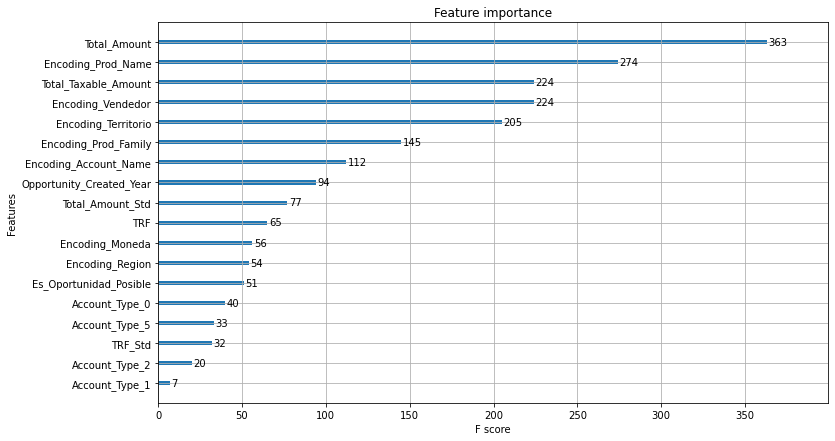

In [622]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)